## Practical work in AI

1. Image preprocessing

The images are not sorted in the right way: can't figure out which domain belongs to which images.
I wrote a script to perform sorting based on the domain names that are present in the UNPROCESSED Retouch images.
Now, I have a list of dicts for the source images and a list of dicts for the target images.

2. Image augmentation

    Main problem currently: SVD is slow (0.6 seconds/image just for the decomposition!)
    the entire dataset in batches of 16, dataloading alone takes more than 5 minutes!

    

3. Training

    How many output channels does my network? 2? How many classes do I actually have? i guess 3, since in the paper they use 3 biomarkers
       

In [1]:
import numpy as np

from pathlib import Path
import os
from typing import *
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler

import monai
from monai.transforms import *
from monai.config.type_definitions import KeysCollection

import segmentation_models_pytorch as smp

import albumentations as A

import wandb

# Imports from local files
from transforms import *
from dataset import OCTDatasetPrep, MakeDataset
from utils import *


# Set random seed
np.random.seed(99)
torch.manual_seed(99)

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: moritsih. Use `wandb login --relogin` to force relogin


True

## Paths to the data

In [2]:
class Config():

    def __init__(self):

        # paths
        # directory where img folders are still sorted by domain (but unprocessed OCT images)
        self.name_dir = Path(Path.cwd() / 'data/RETOUCH/TrainingSet-Release/') 
        # already processed OCT images but unsorted by domain (sorting happens in dataset class)
        self.train_dir = Path(Path.cwd() / 'data/Retouch-Preprocessed/train') 
        self.model_path = Path(Path.cwd() / 'models')


        self.source_domains = ['Spectralis', 'Topcon', 'Cirrus']


        # transforms
        self.train_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']), # if SVDNA should not be performed, uncomment this and comment the following two lines
                                        #SVDNA(keys=['img'], histogram_matching_degree=.5),
                                        #CustomImageLoader(keys=['label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        #Lambdad(keys=['img', 'label', 'masks'], func = lambda x: 2*(x - x.min()) / (x.max() - x.min()) - 1 ),  # -1 to 1 scaling
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[496, 1024]),
                                        SpatialPadd(keys=['img', 'label', 'masks'], spatial_size=[512, 1024], mode='constant'),
                                        #RandZoomd(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], prob=0.3, min_zoom=0.5, max_zoom=1.5),
                                        #RandAxisFlipd(keys=["img", "label", 'masks'], prob=0.3),
                                        #RandAffined(keys=["img", "label", 'masks'], 
                                        #            prob=0.3, 
                                        #            shear_range=[0, 0],
                                        #            translate_range=[0, 0],
                                        #            rotate_range=[0, 0],
                                        #            mode=["bilinear", "nearest", "nearest"], 
                                        #            padding_mode="zeros"),      
                                        #Debugging(keys=['img', 'label', 'masks']),
                                        ])


        self.val_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[496, 1024]),
                                        SpatialPadd(keys=['img', 'label', 'masks'], spatial_size=[512, 1024], mode='constant'),
                                        
                                    ])
        
        
        self.test_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[496, 1024]),
                                        SpatialPadd(keys=['img', 'label', 'masks'], spatial_size=[512, 1024], mode='constant'),
                                    ])

        # device
        if torch.backends.mps.is_available():
            self.device = 'mps'
        elif torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        # models
        self.model_parameters_unet = {
            'spatial_dims': 2,
            'in_channels': 1,
            'out_channels': 3,
            'channels': (16, 32, 64, 128, 256),
            'strides': (2, 2, 2, 2),
            'num_res_units': 2,
            'bias': False,
            'dropout':0.1
        }


        self.encoder_name = "resnet18"


        # optimizer

        self.lr = 1e-4
        self.weight_decay = 0.003


        # hyperparams
        self.batch_size = 3
        self.epochs = 100




In [3]:
# leftover transforms I keep for later
'''
    #GetMaskPositions(keys=['masks'], target_keys=["mask_positions"]), #We get the layer position, but on the original height
    #LayerPositionToProbabilityMap(["mask_positions"], target_size=(400,400), target_keys=["mask_probability_map"]),

    #Resized(keys=["img", "label", "masks"], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 400]),
    #Lambdad(keys=['mask_positions'], func = lambda x: x * 400 / 800), #We scale down the positions to have more accurate positions
    #Lambdad(keys=['img'], func = lambda x: np.clip((x - x.mean()) / x.std(), -1, 1)), 
'''

'\n    #GetMaskPositions(keys=[\'masks\'], target_keys=["mask_positions"]), #We get the layer position, but on the original height\n    #LayerPositionToProbabilityMap(["mask_positions"], target_size=(400,400), target_keys=["mask_probability_map"]),\n\n    #Resized(keys=["img", "label", "masks"], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 400]),\n    #Lambdad(keys=[\'mask_positions\'], func = lambda x: x * 400 / 800), #We scale down the positions to have more accurate positions\n    #Lambdad(keys=[\'img\'], func = lambda x: np.clip((x - x.mean()) / x.std(), -1, 1)), \n'

## Initialize Config

In [4]:
cfg = Config()
#cfg.device = "cpu"

Training set: 3505
Validation set: 1001
Test set: 502
Image 1, Channel 1:
Mean: 0.96875
Min: 0.0
Max: 1.0
Unique values: [0. 1.]

Image 1, Channel 2:
Mean: 0.0
Min: 0.0
Max: 0.0
Unique values: [0.]

Image 1, Channel 3:
Mean: 0.0
Min: 0.0
Max: 0.0
Unique values: [0.]

Image 1, Channel 4:
Mean: 0.0
Min: 0.0
Max: 0.0
Unique values: [0.]



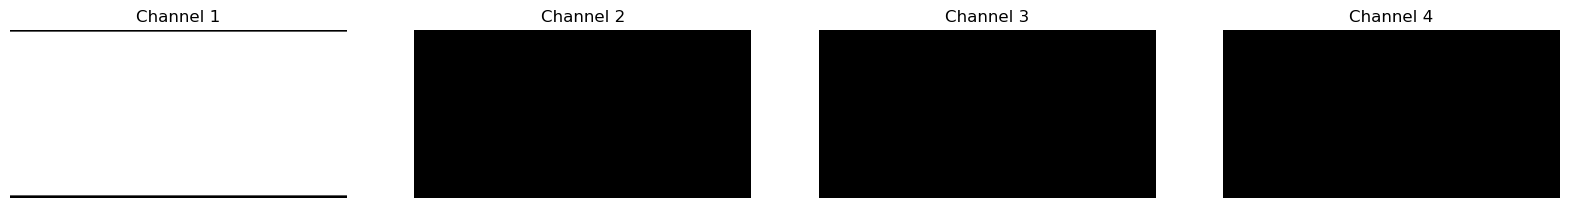

Image 2, Channel 1:
Mean: 0.9497184753417969
Min: 0.0
Max: 1.0
Unique values: [0. 1.]

Image 2, Channel 2:
Mean: 0.019031524658203125
Min: 0.0
Max: 1.0
Unique values: [0. 1.]

Image 2, Channel 3:
Mean: 0.0
Min: 0.0
Max: 0.0
Unique values: [0.]

Image 2, Channel 4:
Mean: 0.0
Min: 0.0
Max: 0.0
Unique values: [0.]



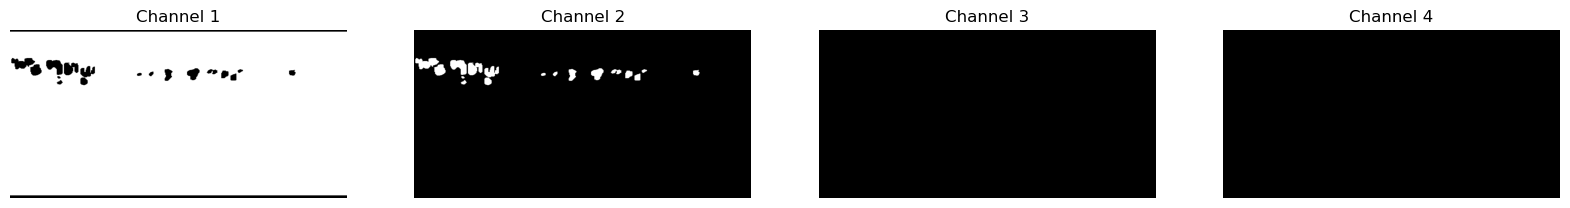

Image 3, Channel 1:
Mean: 0.9676704406738281
Min: 0.0
Max: 1.0
Unique values: [0. 1.]

Image 3, Channel 2:
Mean: 0.001079559326171875
Min: 0.0
Max: 1.0
Unique values: [0. 1.]

Image 3, Channel 3:
Mean: 0.0
Min: 0.0
Max: 0.0
Unique values: [0.]

Image 3, Channel 4:
Mean: 0.0
Min: 0.0
Max: 0.0
Unique values: [0.]



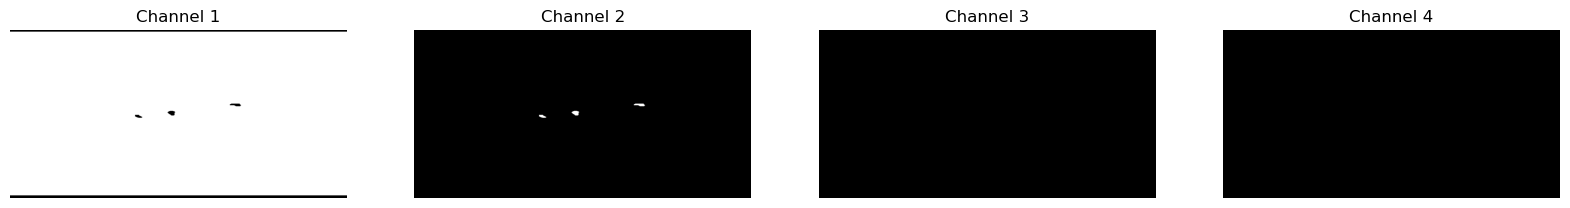

Image 4, Channel 1:
Mean: 0.96875
Min: 0.0
Max: 1.0
Unique values: [0. 1.]

Image 4, Channel 2:
Mean: 0.0
Min: 0.0
Max: 0.0
Unique values: [0.]

Image 4, Channel 3:
Mean: 0.0
Min: 0.0
Max: 0.0
Unique values: [0.]

Image 4, Channel 4:
Mean: 0.0
Min: 0.0
Max: 0.0
Unique values: [0.]



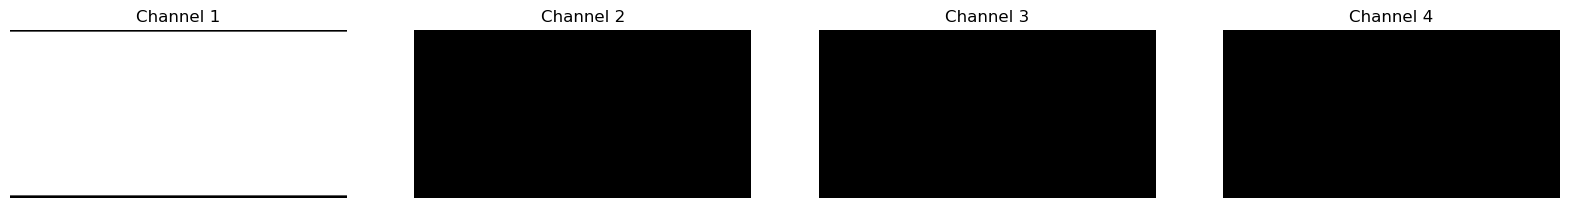

Image 5, Channel 1:
Mean: 0.9498786926269531
Min: 0.0
Max: 1.0
Unique values: [0. 1.]

Image 5, Channel 2:
Mean: 0.018871307373046875
Min: 0.0
Max: 1.0
Unique values: [0. 1.]

Image 5, Channel 3:
Mean: 0.0
Min: 0.0
Max: 0.0
Unique values: [0.]

Image 5, Channel 4:
Mean: 0.0
Min: 0.0
Max: 0.0
Unique values: [0.]



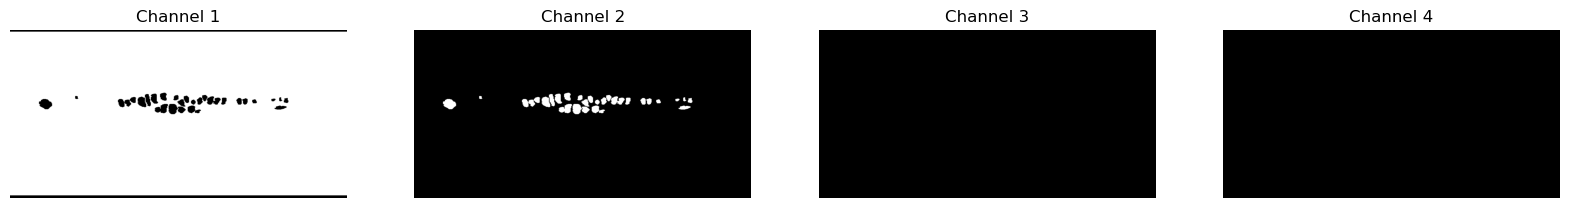

In [26]:
print_some_imgs = False

if print_some_imgs:
    
    transforms_visualize = Compose([cfg.train_transforms])
    #transforms_visualize = Compose([cfg.train_transforms, ImageVisualizer(keys=['img', 'label', 'masks'])])
    train_data_raw, _, _ = OCTDatasetPrep(cfg.train_dir, source_domains=cfg.source_domains).get_datasets(use_official_testset=False)
    train_data = MakeDataset(train_data_raw, transforms_visualize)


    for i in range(4):
 
        rand_num = np.random.randint(0, len(train_data))
        sample = train_data[rand_num]
        print(f"Sample {i+1}", 
              "\nImg: ", sample['img'].shape,
              "\nLabel: ", sample['label'].shape,
              "\nMasks: ", sample['masks'].shape)




## Architecture, dataset, loss function, optimizer

In [5]:
def get_model(cfg):

    return smp.UnetPlusPlus(encoder_name=cfg.encoder_name,
                             encoder_weights="imagenet",
                             decoder_channels = (1024, 512, 256, 128, 64),
                             in_channels=1,
                             classes=4,
                             decoder_attention_type="scse")

In [6]:
if not os.path.isdir('models'):
    os.mkdir('models')

if not os.path.isdir('val_predictions'):
    os.mkdir('val_predictions')


print("Device: ", cfg.device)


#model = monai.networks.nets.UNet(**cfg.model_parameters_unet).to(cfg.device)
model = get_model(cfg).to(cfg.device)


#include background is important: we don't want the large amount of background pixels to dominate the loss
criterion = monai.losses.DiceCELoss(include_background=True,
                                    sigmoid=True)

optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)


# plotting LR at bottom of the notebook
#start_lr = 1
#end_lr = 1

#scheduler1 = lr_scheduler.LinearLR(optimizer, start_lr, end_lr)
#scheduler2 = lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs/7, eta_min=5e-2) # cycle 7 times during training

#scheduler = lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[30]) # switch to Cosine after 50 epochs

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)

train_data, val_data, _ = OCTDatasetPrep(cfg.train_dir).get_datasets(dataset_split=[0.01, 0.003])

train_dataset = MakeDataset(train_data, cfg.train_transforms)
val_dataset = MakeDataset(val_data, cfg.val_transforms)
#test_dataset = MakeDataset(test_data, cfg.test_transforms)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=0)
#test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=0)


Device:  mps
Training set: 50
Validation set: 15
Test set: 4943


img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


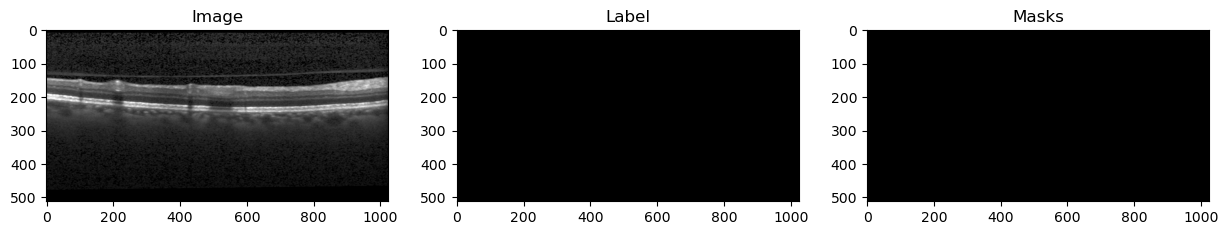

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


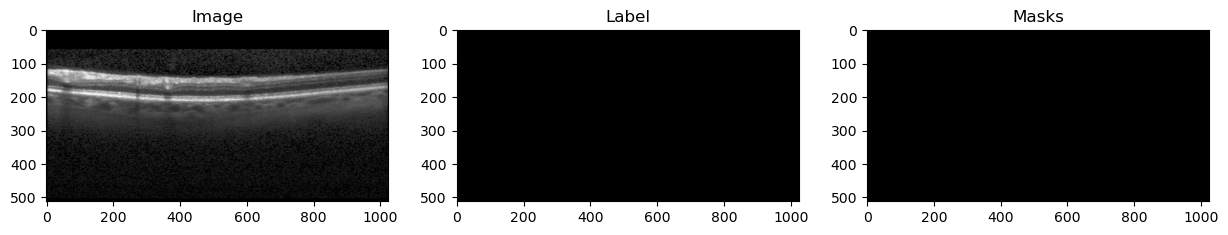

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


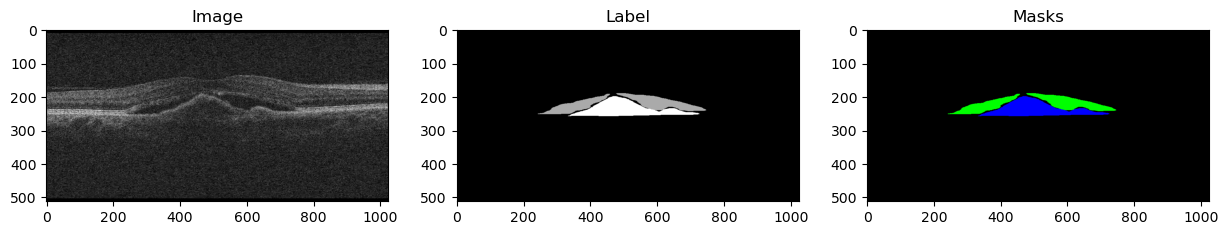

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


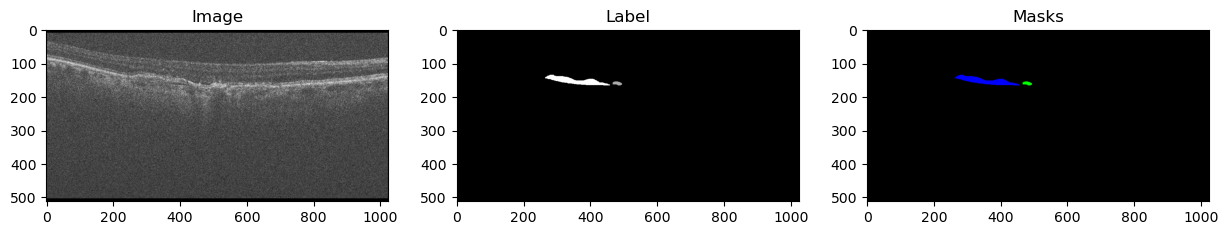

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


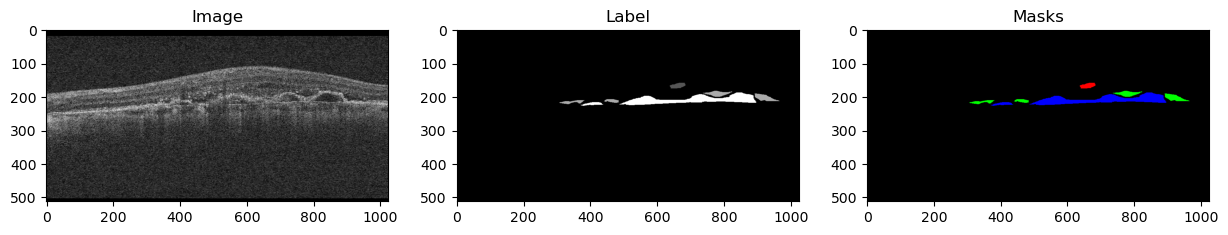

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


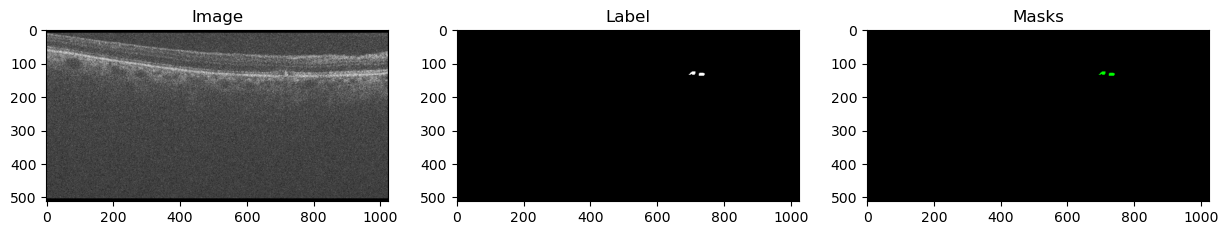

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


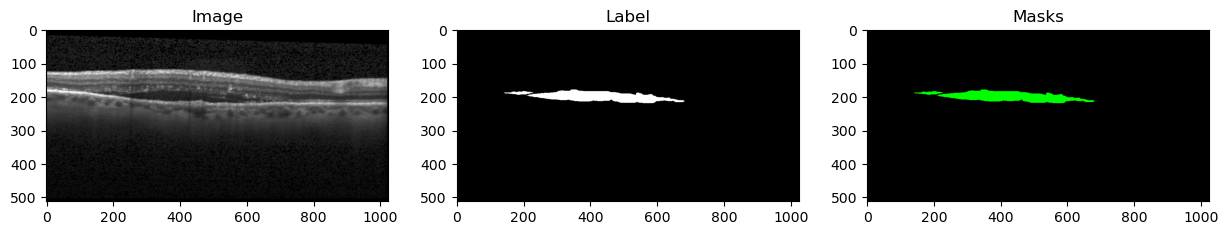

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


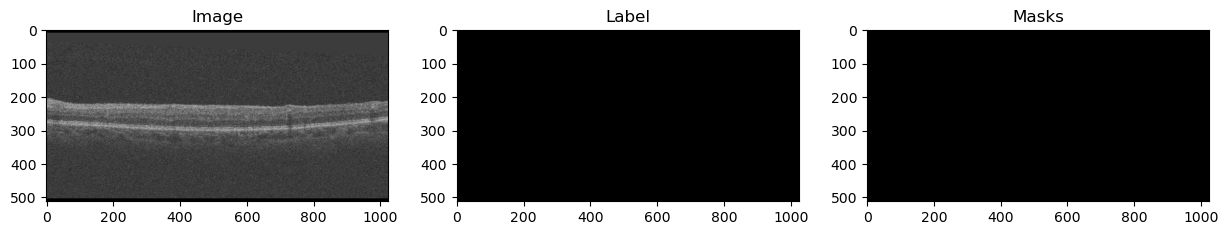

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


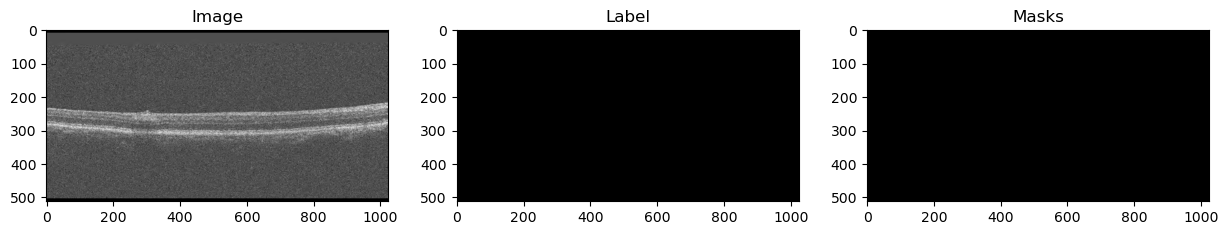

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


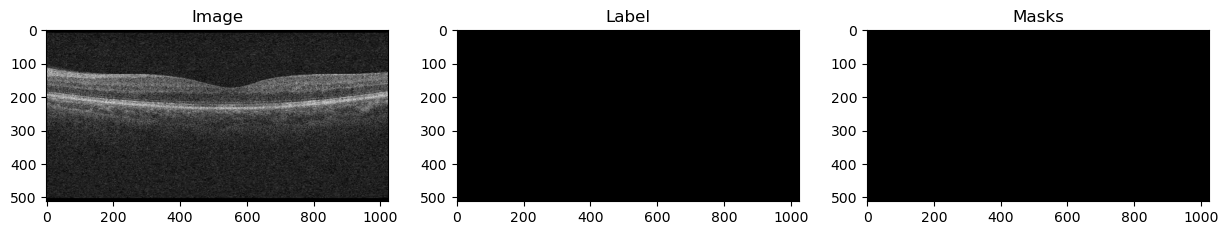

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


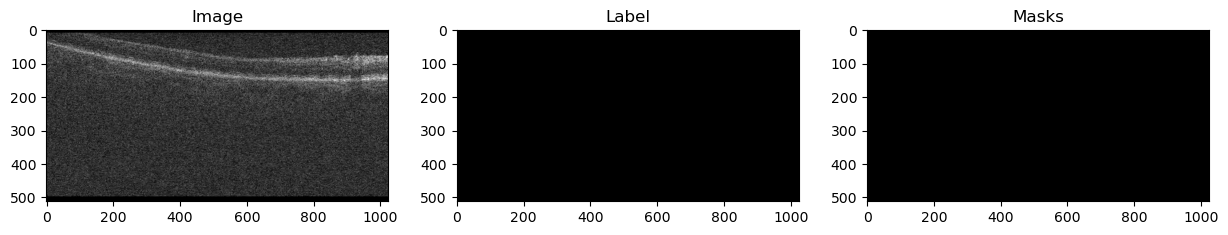

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


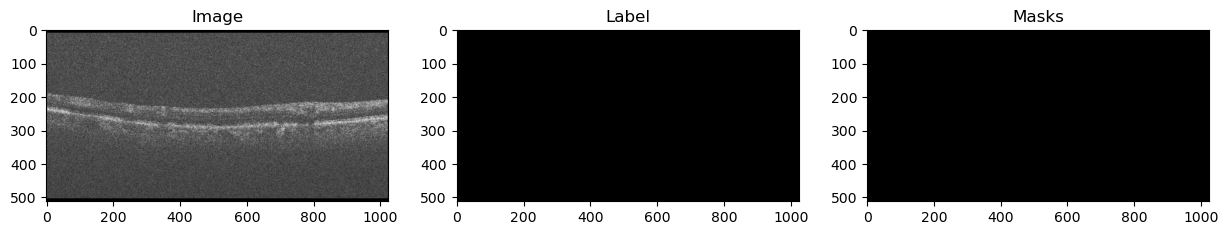

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


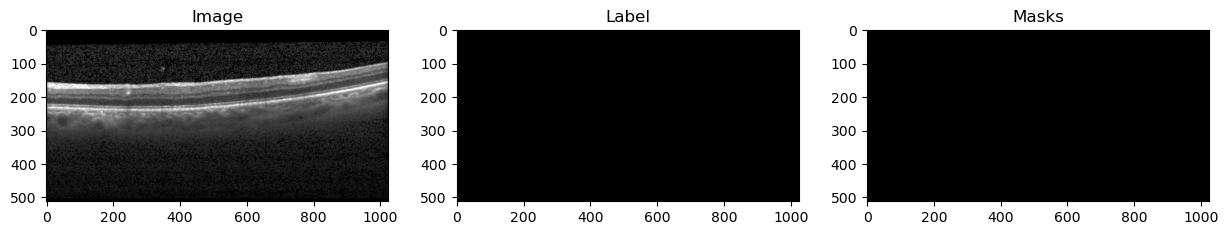

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


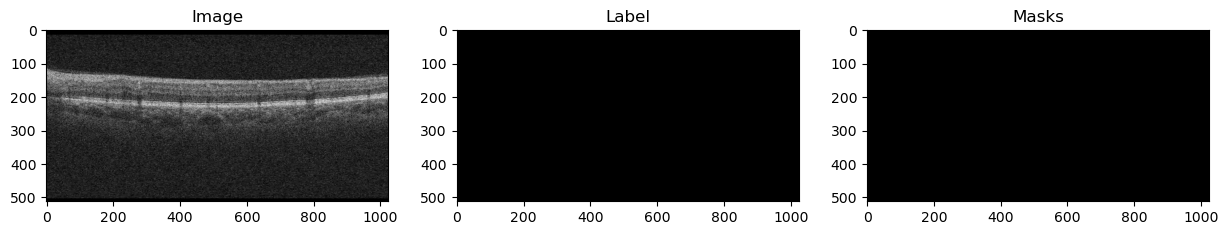

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


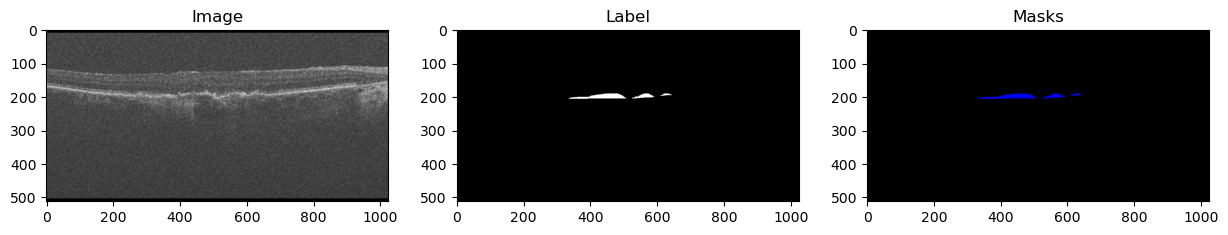

img:  torch.Size([3, 1, 512, 1024])
label:  torch.Size([3, 1, 512, 1024])
masks:  torch.Size([3, 4, 512, 1024])


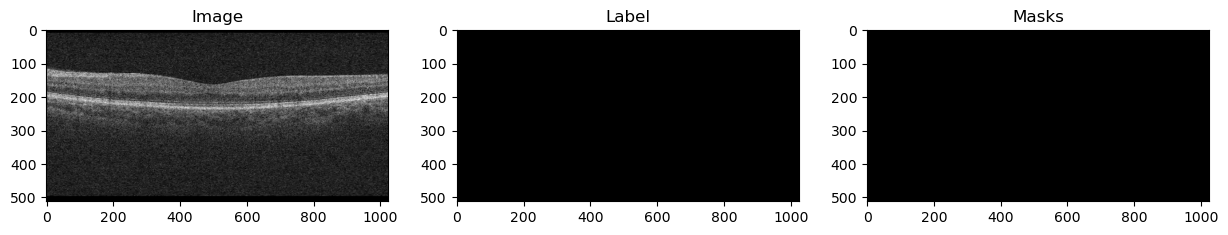

img:  torch.Size([2, 1, 512, 1024])
label:  torch.Size([2, 1, 512, 1024])
masks:  torch.Size([2, 4, 512, 1024])


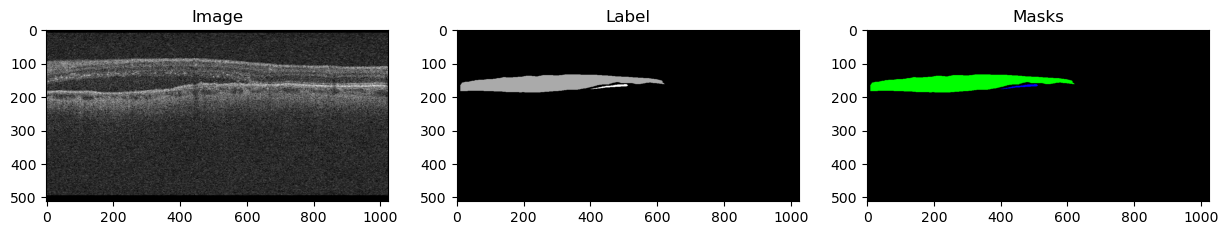

In [34]:
plot_some_more_imgs = False

if plot_some_more_imgs:
    for i, batch in enumerate(train_loader):
        print("img: ", batch['img'].shape)
        print("label: ", batch['label'].shape)
        print("masks: ", batch['masks'].shape)

        # plot each of the images
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(batch['img'][0, 0], cmap='gray')
        ax[0].set_title('Image')
        ax[1].imshow(batch['label'][0, 0], cmap='gray')
        ax[1].set_title('Label')
        ax[2].imshow(np.transpose(batch['masks'][0, 1:], (1, 2, 0)))
        ax[2].set_title('Masks')

        plt.show()

In [9]:
'''
# Run a sample input through the model
sample = next(iter(train_loader))
print(type(sample['img']))
print({k: v.shape for k, v in sample.items()})
sample_input = sample['img'].to(cfg.device)  # assuming 'image' is the key for images
sample_output = model(sample_input)

print(sample_output.shape)

# Compute the loss for a sample output and a sample target
sample_target = sample['masks'].to(cfg.device)  # assuming 'label' is the key for labels
sample_loss = criterion(sample_output, sample_target)
print(sample_loss)'''

"\n# Run a sample input through the model\nsample = next(iter(train_loader))\nprint(type(sample['img']))\nprint({k: v.shape for k, v in sample.items()})\nsample_input = sample['img'].to(cfg.device)  # assuming 'image' is the key for images\nsample_output = model(sample_input)\n\nprint(sample_output.shape)\n\n# Compute the loss for a sample output and a sample target\nsample_target = sample['masks'].to(cfg.device)  # assuming 'label' is the key for labels\nsample_loss = criterion(sample_output, sample_target)\nprint(sample_loss)"

In [10]:
'''
pred = torch.sigmoid(sample_output)

# thresholding
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

plot_img_label_pred(sample_input, pred, sample_target)'''

'\npred = torch.sigmoid(sample_output)\n\n# thresholding\npred[pred > 0.5] = 1\npred[pred <= 0.5] = 0\n\nplot_img_label_pred(sample_input, pred, sample_target)'

## Run the thing

In [7]:
train_the_thing = False

if train_the_thing:

    model = load_model(model, cfg.model_path / 'model_trial_withbg.pth')

    wandb_config = {
        'batch_size': cfg.batch_size,
        'lr': optimizer.param_groups[0]['lr'],
        'epochs': cfg.epochs,
        'device': cfg.device,
        'model': 'UNet++ Resnet18 encoder',
        'dataset': 'Retouch',
        'model_parameters': cfg.model_parameters_unet,
    }

    with wandb.init(project='PracticalWorkinAI', 
                    config=wandb_config,
                    name='smp Unet++ small dataset and bg') as run:
        wandb_config = wandb.config
        
        model = train(model, 
                    train_loader, val_loader, 
                    criterion, optimizer, scheduler, cfg.device, 
                    epochs=cfg.epochs, 
                    save_path= cfg.model_path / 'model_trial_withbg.pth')

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Batch 1/17, Loss: 2.9498
Batch 2/17, Loss: 2.6395
Batch 3/17, Loss: 2.4091
Batch 4/17, Loss: 2.2766
Batch 5/17, Loss: 2.1709
Batch 6/17, Loss: 2.0754
Batch 7/17, Loss: 1.9878
Batch 8/17, Loss: 1.9127
Batch 9/17, Loss: 1.8696
Batch 10/17, Loss: 1.8284
Batch 11/17, Loss: 1.7423
Batch 12/17, Loss: 1.7391
Batch 13/17, Loss: 1.6598
Batch 14/17, Loss: 1.5871
Batch 15/17, Loss: 1.5653
Batch 16/17, Loss: 1.5381
Batch 17/17, Loss: 1.4886


Training:   1%|          | 1/100 [06:06<10:05:31, 366.99s/epoch]

Batch 1/17, Loss: 1.4539
Batch 2/17, Loss: 1.4150
Batch 3/17, Loss: 1.4006
Batch 4/17, Loss: 1.3517
Batch 5/17, Loss: 1.3132
Batch 6/17, Loss: 1.2641
Batch 7/17, Loss: 1.2481
Batch 8/17, Loss: 1.2161
Batch 9/17, Loss: 1.1959
Batch 10/17, Loss: 1.1548
Batch 11/17, Loss: 1.1749
Batch 12/17, Loss: 1.1217
Batch 13/17, Loss: 1.1111
Batch 14/17, Loss: 1.0950
Batch 15/17, Loss: 1.0821


Training:   1%|          | 1/100 [12:06<19:58:20, 726.27s/epoch]
Traceback (most recent call last):
  File "/var/folders/gq/0ththbw90js42dvy_79_9qt00000gn/T/ipykernel_96175/3664546541.py", line 18, in <module>
    model = train(model,
  File "/Users/moritz/Documents/Master/OPTIMA_Masterarbeit/practical/utils.py", line 123, in train
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
  File "/Users/moritz/Documents/Master/OPTIMA_Masterarbeit/practical/utils.py", line 29, in train_one_epoch
    outputs = model(inputs)#[0]
  File "/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1561, in _call_impl
    result = forward_call(*args, **kwargs)
  File "/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/segmentation_models_

best_loss,▁
epoch,▁
lr,▁
train_loss,▁
val_loss,▁▁
best_loss,2.12178
epoch,1
lr,0.0001
train_loss,1.96707
val_loss,2.12178


RuntimeError: MPS backend out of memory (MPS allocated: 15.12 GB, other allocations: 2.86 GB, max allowed: 18.13 GB). Tried to allocate 384.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [21]:
# load saved model and make predictions on random images from the validation set
model = load_model(model, cfg.model_path / 'model_trial.pth')
model.eval()

for i in range(4):
    rand_num = np.random.randint(0, len(val_dataset))
    sample = val_dataset[rand_num]

    img = sample['img'].unsqueeze(0).to(cfg.device)
    mask = sample['masks'].unsqueeze(0).to(cfg.device)

    pred = model(img)
    pred = torch.sigmoid(pred)
    
    # thresholding
    pred[pred > 0.5] = 1
    pred[pred <= 0.5] = 0

    plot_img_label_pred(img, pred, mask)

torch.Size([4, 512, 1024])
channel  0
mean:  1.0
min:  1.0
max:  1.0
unique:  [1.]
channel  1
mean:  0.0
min:  0.0
max:  0.0
unique:  [0.]
channel  2
mean:  0.0
min:  0.0
max:  0.0
unique:  [0.]
channel  3
mean:  0.0
min:  0.0
max:  0.0
unique:  [0.]
torch.Size([4, 512, 1024])
channel  0
mean:  1.0
min:  1.0
max:  1.0
unique:  [1.]
channel  1
mean:  0.0
min:  0.0
max:  0.0
unique:  [0.]
channel  2
mean:  0.0
min:  0.0
max:  0.0
unique:  [0.]
channel  3
mean:  0.0
min:  0.0
max:  0.0
unique:  [0.]
torch.Size([4, 512, 1024])
channel  0
mean:  1.0
min:  1.0
max:  1.0
unique:  [1.]
channel  1
mean:  0.0
min:  0.0
max:  0.0
unique:  [0.]
channel  2
mean:  0.0
min:  0.0
max:  0.0
unique:  [0.]
channel  3
mean:  0.0
min:  0.0
max:  0.0
unique:  [0.]
torch.Size([4, 512, 1024])
channel  0
mean:  1.0
min:  1.0
max:  1.0
unique:  [1.]
channel  1
mean:  0.0
min:  0.0
max:  0.0
unique:  [0.]
channel  2
mean:  0.0
min:  0.0
max:  0.0
unique:  [0.]
channel  3
mean:  0.0
min:  0.0
max:  0.0
unique:  [

/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


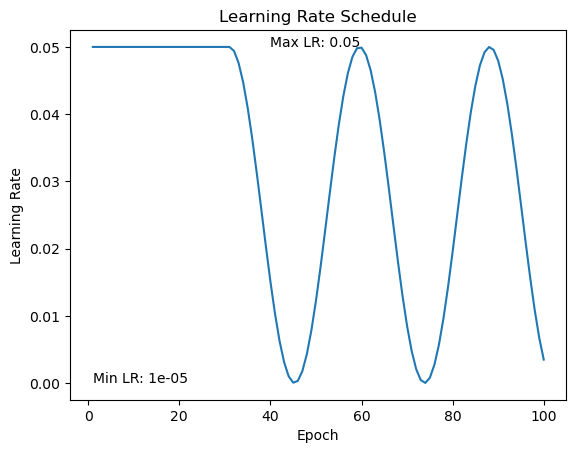

In [16]:
def plot_lr(optimizer, scheduler, num_steps):
    
    lr_values = []
    fake_val_loss = np.arange(1e-4, 2, 1e-2)[::-1]

    for i in range(num_steps):
        lr = scheduler.get_last_lr()

        lr_values.append(lr)
        optimizer.step()
        scheduler.step()

    # Plot the learning rate values
    plt.plot(range(1, num_steps+1), lr_values)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')

    # Add the maximum and minimum learning rate values
    max_lr = max(lr_values)[0]
    min_lr = min(lr_values)[0]

    plt.text(40, max_lr, f'Max LR: {max_lr}')
    plt.text(1, np.round(min_lr,5), f'Min LR: {np.round(min_lr,5)}')

    plt.show()

model = monai.networks.nets.UNet(**cfg.model_parameters_unet)
optimizer = optim.Adam(model.parameters(), lr=5e-2)


start_lr = 1
end_lr = 1

scheduler1 = lr_scheduler.LinearLR(optimizer, start_lr, end_lr)
scheduler2 = lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs/7, eta_min=1e-6) # cycle 7 times during training

scheduler = lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[30]) # switch to Cosine after 50 epochs

plot_lr(optimizer, scheduler, 100)